In [1]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (SingleEPI_CC,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load data
data_dir = '/home/omar/data/topup_example/'

epi_fname = data_dir + "b0_blipup.nii"
nonepi_fname = data_dir + "b0_blipup_unwarped.nii"

epi_nib = nib.load(epi_fname)
epi_affine = epi_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(epi_affine, 3)
epi = epi_nib.get_data().squeeze().astype(np.float64)

nonepi_nib = nib.load(nonepi_fname)
nonepi_affine = nonepi_nib.get_affine()
nonepi = nonepi_nib.get_data().squeeze().astype(np.float64)


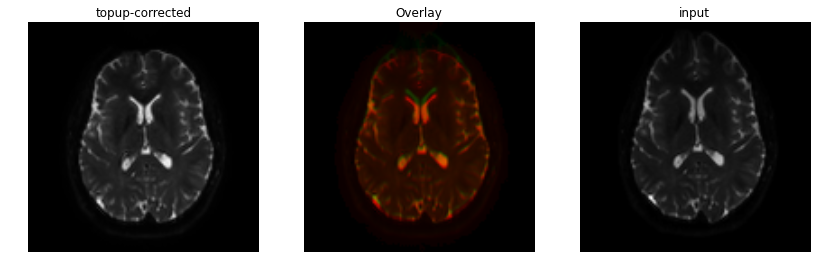

In [14]:
# We want to correct an EPI by registering it towards a non-epi (undistorted) using CC with Jacobian modulation
# Let's use the top-up corrected image as a `non-epi`
rt.overlay_slices(nonepi, epi, slice_type=2, ltitle='topup-corrected', rtitle='input');

In [15]:
radius = 4

# Preprocess intensities
epi /= epi.mean()
nonepi /= nonepi.mean()

# Configure and run orfield estimation
pedir_epi = np.array((0,1,0), dtype=np.float64)
pedir_nonepi = np.array((0,0,0), dtype=np.float64)

distortion_model = SingleEPI_CC(radius=radius)

level_iters = np.array([200, 200, 200, 200, 200, 200, 200, 200, 200])
lambdas = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.05, 0.05])*300
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0])

estimator = OffResonanceFieldEstimator(distortion_model, level_iters=level_iters, lambdas=lambdas, fwhm=fwhm)

orfield_coef_fname = 'orfield_coef_single_cc_ss.p'
orfield = None
if os.path.isfile(orfield_coef_fname):
    coef = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(epi.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield = estimator.optimize_with_ss(nonepi, nonepi_affine, pedir_nonepi, epi, epi_affine, pedir_epi, spacings)
    pickle.dump(np.array(orfield.coef), open(orfield_coef_fname, 'w'))



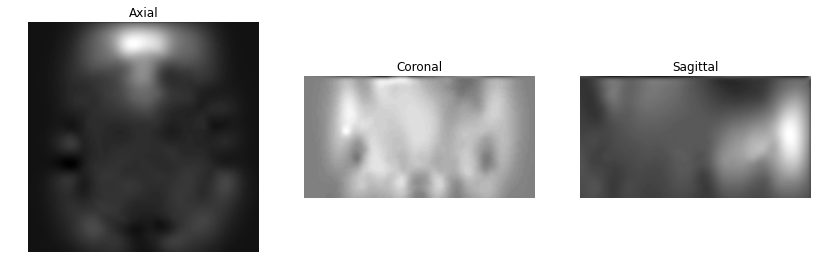

In [16]:
# Warp and modulte images
b  = np.array(orfield.get_volume((0, 0, 0)))
db = np.array(orfield.get_volume((0, 1, 0)))
shape = np.array(epi.shape, dtype=np.int32)
w_epi, _m = gr.warp_with_orfield(epi, b, pedir_epi, None,
                                None, None, shape)
# Show the estimated off-resonance field
rt.plot_slices(b);

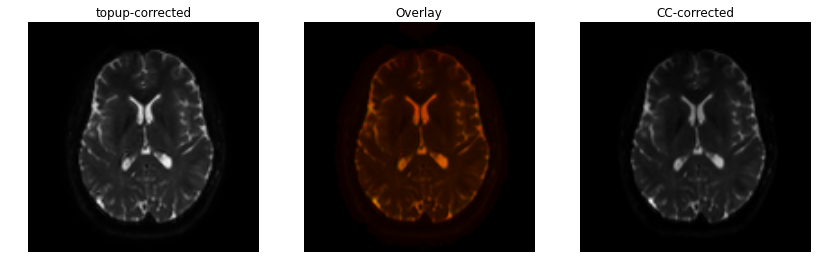

In [17]:
# Show the corrected image (without Jacobian modulation)
rt.overlay_slices(nonepi, w_epi, slice_type=2, ltitle='topup-corrected', rtitle='CC-corrected');


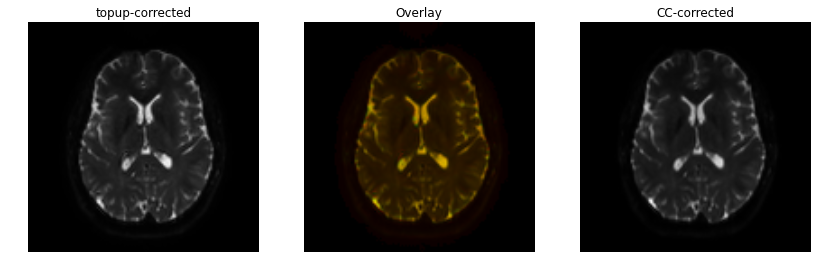

In [18]:
# Show the corrected image (with Jacobian modulation)
rt.overlay_slices(nonepi, w_epi*(1+db), slice_type=2, ltitle='topup-corrected', rtitle='CC-corrected');